# Moore Machines
This notebook explores implementing the [finite state](https://en.wikipedia.org/wiki/Finite-state_machine) machine of a moore diagram by parsing a [wiring diagram](https://algebraicjulia.github.io/Catlab.jl/dev/generated/wiring_diagrams/wiring_diagram_basics/) from Catlab.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz

In [20]:
# Helper function to show graph
show_diagram(d::WiringDiagram) = to_graphviz(d, orientation=LeftToRight, labels=true)

show_diagram (generic function with 1 method)

In [ ]:
# Display table of results

function printResult(x, s)
    # Legend
    println("x | s")
    println("-----")
    # Rows
    for i = 1:length(x)
        println( x[i], " | ", s[i] )
    end
end

---
# Parsing a graph

One way to implement a moore machine is to directly use the diagram to determine a return value. After all, it encodes the information to determine the state, what inputs are acceptable, and how one state transfers to the other.   

The concept is simple:  
Use a wiring diagram and construct a function using the rules from a moore machine. This function receives one input and returns the current state. One requires a readout function to determine the output of the function given the state. The diagram just determines the state given an input.

In [19]:
# Source: https://github.com/AlgebraicJulia/Catlab.jl/blob/master/src/wiring_diagrams/Directed.jl

"""
@auto_hash_equals struct Wire{Value}
  value::Value
  source::Port
  target::Port
end

@auto_hash_equals struct Port
  box::Int
  kind::PortKind
  port::Int
end

@auto_hash_equals struct Box{Value} <: AbstractBox
  value::Value
  input_ports::Vector
  output_ports::Vector
end

boxes(f::WiringDiagram) 
nboxes(f::WiringDiagram) 
box_ids(f::WiringDiagram) 

wires(f::WiringDiagram, type::Symbol)
nwires(f::WiringDiagram, type::Symbol)
out_wires(f::WiringDiagram, b::Int)
""";

In [9]:
mutable struct MooreMachine
    diagram::WiringDiagram
    state_id::Int

    # Constructor
    function MooreMachine( diagram::WiringDiagram, initial_state::Any )                
        # Check initial state
        state_id = findall( box -> box.value == initial_state, boxes(diagram) )
        
        if isempty(state_id) == true
            error("Given state does not exist")
        else 
            new(diagram, state_id[1])  # Use first state that was found
        end
    end
end

In [10]:
## Update the state of a moore machine given an input

function eval_machine(machine::MooreMachine, input::Any)
    # Update state
    trans_input = boxes(machine.diagram)[machine.state_id].output_ports
    
    out_index = findall( x-> x == input, trans_input )
    if isempty(out_index) == true
        error("Input is not defined for state")
    else
        machine.state_id = out_wires(machine.diagram, machine.state_id)[ out_index[1] ].target.box   
    end
    
    # Readout state
    return boxes(machine.diagram)[machine.state_id].value
end


eval_machine (generic function with 1 method)

In [11]:
## Set the current state of a Moore Machine

function set_state(machine::MooreMachine, target_state::Any)
    # Find index of state
    id = findall( box -> box.value == target_state, boxes(machine.diagram) )
    
    # Check if state was found
    if isempty(id)
        error("Given state does not exist")
    else
        machine.state_id = id[1]
    end
end

set_state (generic function with 1 method)

---
### 1. Machine with 2 nodes - Simple graph
Parsing allows use a wiring diagram that matches the diagram of the moore machine. This means there is a one-to-one correspondence between the visual represenation and the excution of the actual function.

<img src="https://raw.githubusercontent.com/rgCategory/composition_notebook/main/images/moore_machine_crop.png" width="40%">

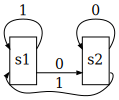

In [12]:
# Construct given diagram
diagram = WiringDiagram([], [])
                        # State, Inputs, Outputs <- These dictate the inputs when evaluating the diagram
s1 = add_box!(diagram, Box(:s1, [1, 0], [1, 0]))
s2 = add_box!(diagram, Box(:s2, [0, 1], [0, 1]))

add_wires!( diagram, [
            (s1, 1) => (s1, 1)
            (s2, 1) => (s2, 1)
            (s1, 2) => (s2, 2)
            (s2, 2) => (s1, 2) ])

# Display
show_diagram(diagram)

In [13]:
# Construct a machine based on the diagram. Requires an initial state
mach = MooreMachine(diagram, :s1);

In [14]:
# Read diagram
inputs = [1, 0, 0, 1, 1,0]                      # Define inputs
sol = map( x -> eval_machine(mach, x), inputs ) # Evalute machine at inputs

# Display
printResult(inputs, sol)

x | s
-----
1 | s1
0 | s2
0 | s2
1 | s1
1 | s1
0 | s2


---
### 2. Machine with 3 nodes

One can repeat the above steps with a more complicated graph. The functions defining the MooreMachine datatype work just as well for this more complex scenario.

<img src="https://www.allaboutcircuits.com/uploads/articles/state-diagram-circuit.jpg" width="35%"/>

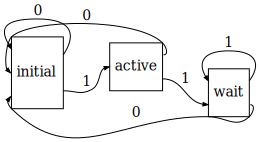

In [15]:
# Construct diagram
diagram = WiringDiagram([], [])
                            # Value, Inputs, Outputs
s1 = add_box!(diagram, Box(:initial, [0, 0, 0], [0, 1]))
s2 = add_box!(diagram, Box(:active, [1], [0, 1]))
s3 = add_box!(diagram, Box(:wait, [1, 1], [1, 0]))

add_wires!( diagram, [
            (s1, 1) => (s1, 1)
            (s3, 1) => (s3, 1)
            (s1, 2) => (s2, 1)
            (s2, 1) => (s1, 2)
            (s2, 2) => (s3, 2)
            (s3, 2) => (s1, 3) ])   

# Display
show_diagram(diagram)

In [16]:
# Construct machine
mach = MooreMachine(diagram, :initial);

# Read diagram
inputs = [1, 0 ,1, 1, 0, 1]
sol = map( x -> eval_machine(mach, x), inputs )

# Display
printResult(inputs, sol)

x | s
-----
1 | active
0 | initial
1 | active
1 | wait
0 | initial
1 | active


---
### 3. Machine with 4 nodes
One can continue to increase the complexity of the diagram and it can be read without issue. This is because the required information is encoded in the diagram itself.

<img src="https://scanftree.com/automata/images/DFA-machine-for-counting-baa.png" width="45%"/>

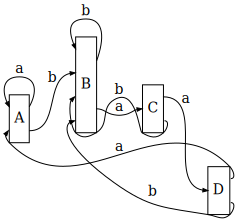

In [17]:
# Construct diagram
diagram = WiringDiagram([], [])
                            # Value, Inputs, Outputs
s1 = add_box!(diagram, Box(:A, [:a, :a], [:a, :b]))
s2 = add_box!(diagram, Box(:B, [:b, :b, :b, :b], [:b, :a]))
s3 = add_box!(diagram, Box(:C, [:a], [:a, :b]))
s4 = add_box!(diagram, Box(:D, [:a], [:a, :b]))

add_wires!( diagram, [
            (s1, 1) => (s1, 1)
            (s1, 2) => (s2, 2)
            (s2, 1) => (s2, 1)
            (s2, 2) => (s3, 1)
            (s3, 1) => (s4, 1)
            (s3, 2) => (s2, 3)
            (s4, 1) => (s1, 2)
            (s4, 2) => (s2, 4) ]) 

# Display
show_diagram(diagram)

In [18]:
# Construct machine
mach = MooreMachine(diagram, :A);

# Read diagram
inputs = [:a, :b, :b, :a, :a, :a]
sol = map( x -> eval_machine(mach, x), inputs )

# Display
printResult(inputs, sol)

x | s
-----
a | A
b | B
b | B
a | C
a | D
a | A
